In [1]:
import numpy as np 
import pandas as pd 
from datetime import datetime, date
import matplotlib.pyplot as plt 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import pmdarima as pm

from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.metrics import mean_squared_error
import warnings
import itertools
import gc
warnings.filterwarnings('ignore')

D:\app\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Background: 
Using the historical order data from weeks 20 – 29, please provide for the next week 30 a daily 
workload planning, per shipping country, for the Logistics team. How many orders can we expect? How 
many shipment cartons will we send? How is the workload distributed between the weekdays? 
Can you think of any other information (data) that is not provided in the set, but could be helpful to 
determine the expected number of orders for the next week? 
Tip: Logistics team is mainly concerned about the processed date of each order.

In [3]:
df1 = pd.read_excel('Project 1 - Order data.xlsx')
df1.head()

,OrderID,Shipping country,SKU,Quantity,Shipment carton number,Payment date,Payment time,Order creation date,Order creation time,Order processed date,Order processed time,Delivery time
0,1012433115,DE,41220,1,12752054,2017-05-14,23:51:54,2017-05-15,00:00:28,2017-05-15,13:12:33,2017-05-17 05:44:00
1,1012433131,DE,130191,1,12743582,2017-05-14,23:52:57,2017-05-15,00:02:40,2017-05-15,10:11:05,2017-05-16 14:06:00
2,1012433132,DE,41166,1,12743661,2017-05-14,23:54:43,2017-05-15,00:02:41,2017-05-15,10:12:33,2017-05-16 09:58:00
3,1012433161,DE,140803,1,12752184,2017-05-14,23:55:12,2017-05-15,00:04:21,2017-05-15,13:15:07,2017-05-17 05:43:00
4,1012433166,NL,273729,1,12731619,2017-05-14,22:04:20,2017-05-15,00:05:53,2017-05-15,06:09:57,2017-05-16 13:20:00


# data distrbution and info check

In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259819 entries, 0 to 259818
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   OrderID                 259819 non-null  int64         
 1   Shipping country        259819 non-null  object        
 2   SKU                     259819 non-null  int64         
 3   Quantity                259819 non-null  int64         
 4   Shipment carton number  259819 non-null  int64         
 5   Payment date            259819 non-null  datetime64[ns]
 6   Payment time            259819 non-null  object        
 7   Order creation date     259819 non-null  datetime64[ns]
 8   Order creation time     259819 non-null  object        
 9   Order processed date    259819 non-null  datetime64[ns]
 10  Order processed time    259819 non-null  object        
 11  Delivery time           259690 non-null  datetime64[ns]
dtypes: datetime64[ns](4), int64(4)

In [5]:
df1.describe()

,OrderID,SKU,Quantity,Shipment carton number,Payment date,Order creation date,Order processed date,Delivery time
count,2.598190e+05,259819.000000,259819.000000,2.598190e+05,259819,259819,259819,259690
mean,1.012980e+09,148500.230849,1.079690,1.343849e+07,2017-06-17 02:59:44.911034112,2017-06-15 20:00:45.613292288,2017-06-17 08:05:21.787090176,2017-06-20 15:37:17.015553024
min,1.012433e+09,10039.000000,1.000000,1.273162e+07,2016-12-09 00:00:00,2017-05-15 00:00:00,2017-05-15 00:00:00,2016-05-25 03:27:00
25%,1.012718e+09,42199.000000,1.000000,1.309858e+07,2017-05-30 00:00:00,2017-05-30 00:00:00,2017-05-31 00:00:00,2017-06-02 14:35:00
50%,1.012986e+09,140014.000000,1.000000,1.342618e+07,2017-06-15 00:00:00,2017-06-14 00:00:00,2017-06-15 00:00:00,2017-06-19 13:11:00
75%,1.013238e+09,240901.000000,1.000000,1.376393e+07,2017-07-03 00:00:00,2017-07-02 00:00:00,2017-07-04 00:00:00,2017-07-06 11:38:00
max,1.013495e+09,412769.000000,65.000000,1.535143e+07,2018-09-06 00:00:00,2017-07-23 00:00:00,2017-10-06 00:00:00,2017-11-23 11:00:00
std,3.039449e+05,107268.027571,0.856941,3.928889e+05,NaN,NaN,NaN,NaN


In [6]:
countries = pd.unique(df1['Shipping country'].values)
countries

array(['DE', 'NL', 'FR', 'CH'], dtype=object)

In [7]:
for i in countries:
    globals()[f'df_{i}'] = df1[df1['Shipping country']==i]
    globals()[f'df_{i}_1'] = globals()[f'df_{i}'][['Quantity','Shipment carton number','Order creation date']].groupby(['Order creation date']).sum().reset_index()

In [8]:
df_DE_1

,Order creation date,Quantity,Shipment carton number
0,2017-05-15,2184,27769155102
1,2017-05-16,1703,20015032717
2,2017-05-17,954,11271513089
3,2017-05-18,2074,26015815954
4,2017-05-19,1819,20703604155
...,...,...,...
65,2017-07-19,1654,18846972918
66,2017-07-20,1499,17864563750
67,2017-07-21,1269,14995686170
68,2017-07-22,1279,14647489841


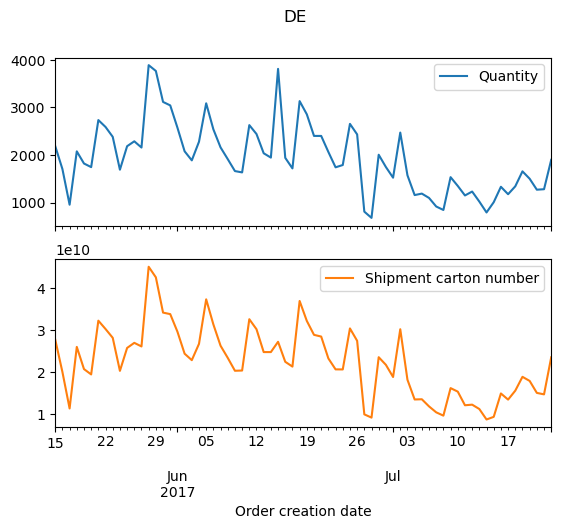

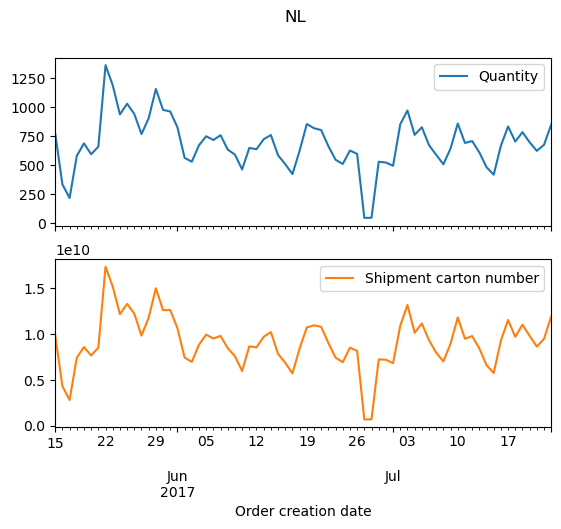

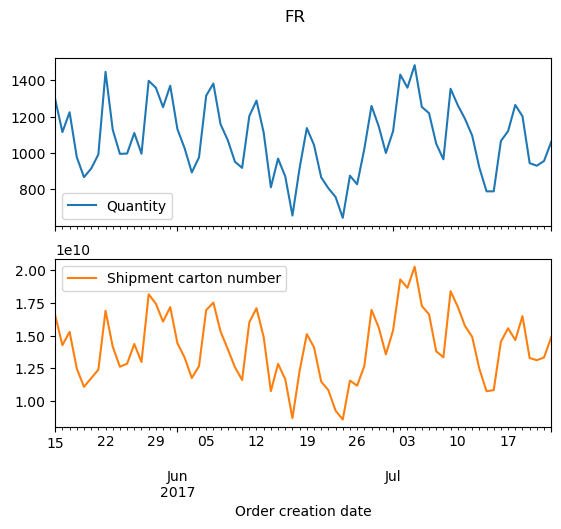

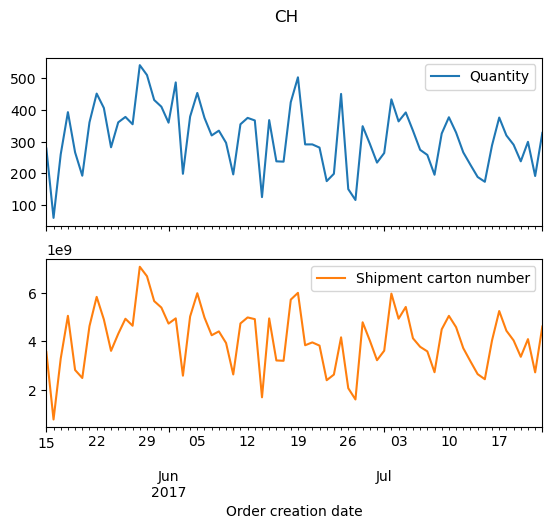

In [9]:
for i in countries:
    globals()[f'df_{i}_1'].plot.line(x='Order creation date',y=['Quantity','Shipment carton number'],title=i,subplots=True)


In [10]:
for i in countries:
    globals()[f'df_{i}_times_c'] = pd.DataFrame(globals()[f'df_{i}_1'].Quantity.values,index =globals()[f'df_{i}_1']['Order creation date'],columns=['Quanitity'])

In [11]:
df_DE_times_c

,Quanitity
Order creation date,
2017-05-15,2184
2017-05-16,1703
2017-05-17,954
2017-05-18,2074
2017-05-19,1819
...,...
2017-07-19,1654
2017-07-20,1499
2017-07-21,1269


Quantity has same distrbution with Shipment carton number, so only need to analysz one

In [12]:
def decompose(df1_q, country):
    # Multiplicative Decomposition 
    result_mul = seasonal_decompose(df1_q, model='multiplicative', extrapolate_trend='freq')

    # Additive Decomposition
    result_add = seasonal_decompose(df1_q, model='additive', extrapolate_trend='freq')

    # Plot
    plt.rcParams.update({'figure.figsize': (5,5)})
    result_mul.plot().suptitle(f'{country} Multiplicative Decompose', fontsize=12)
    result_add.plot().suptitle(f'{country} Additive Decompose', fontsize=12)
    plt.show()

    # Extract the Components ----# Actual Values = Product of (Seasonal * Trend * Resid)
    df_reconstructed = pd.concat([result_mul.seasonal, result_mul.trend, result_mul.resid, result_mul.observed], axis=1)
    df_reconstructed.columns = ['Seasonality', 'trend', 'resid', 'actual_values']


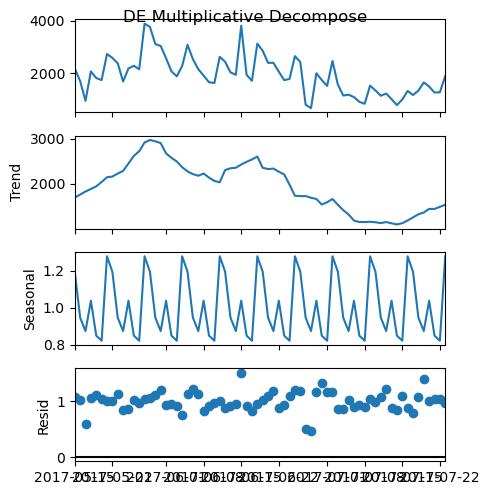

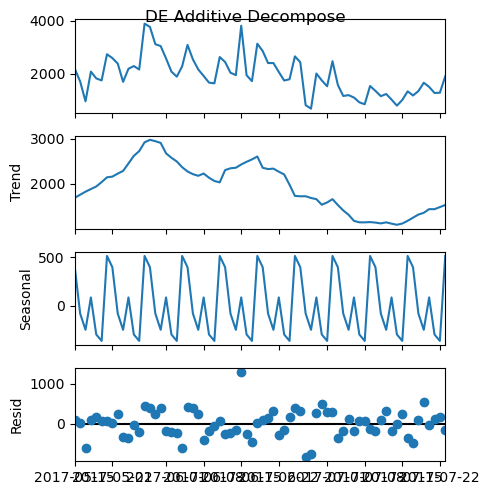

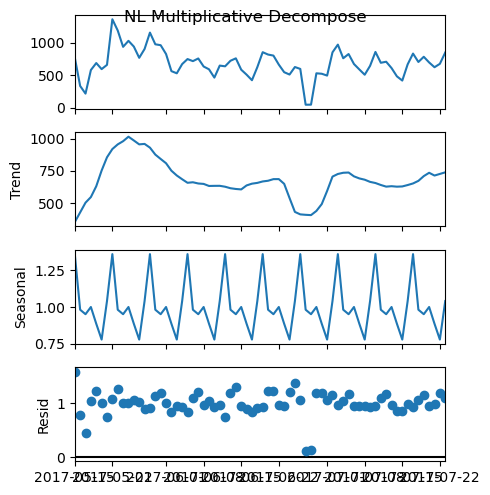

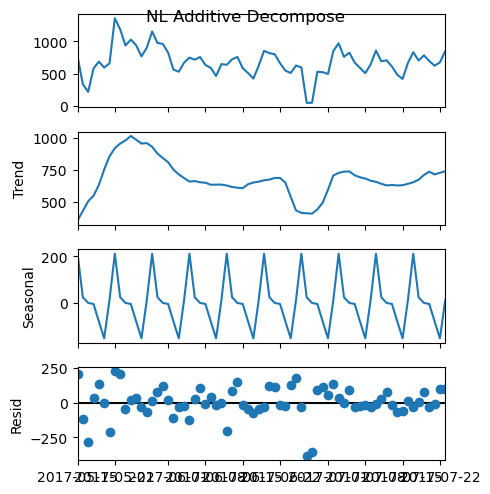

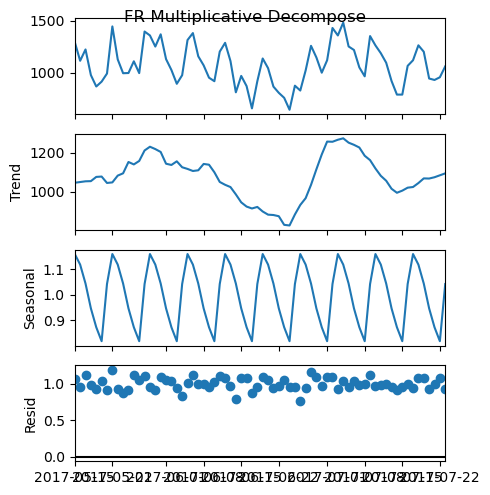

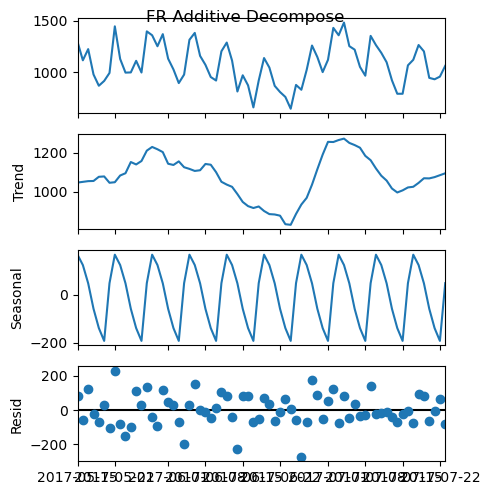

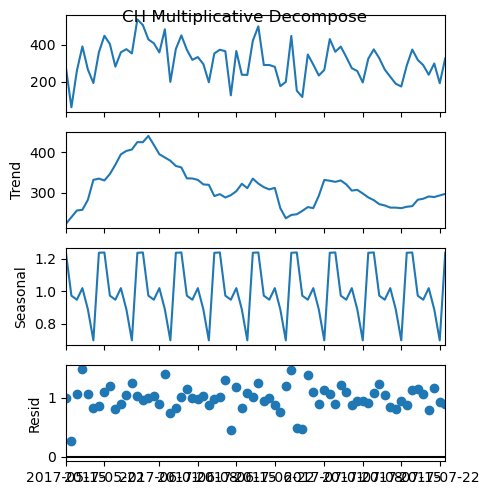

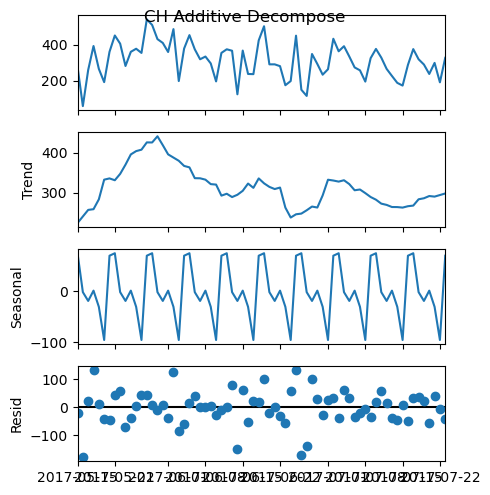

In [13]:
#decompose all shipping country
for i in countries:
    decompose(globals()[f'df_{i}_times_c'],i )

# stationary check

In [14]:
df_CH_times_c.iloc[:,0]

Order creation date
2017-05-15    278
2017-05-16     61
2017-05-17    260
2017-05-18    392
2017-05-19    266
             ... 
2017-07-19    290
2017-07-20    238
2017-07-21    299
2017-07-22    192
2017-07-23    327
Name: Quanitity, Length: 70, dtype: int64

In [15]:
df_CH_times_c.diff()

,Quanitity
Order creation date,
2017-05-15,NaN
2017-05-16,-217.0
2017-05-17,199.0
2017-05-18,132.0
2017-05-19,-126.0
...,...
2017-07-19,-29.0
2017-07-20,-52.0
2017-07-21,61.0


In [16]:

def differnce(data,country):
    result = adfuller(data.dropna())
    print(f'{country} p-value: %f' % result[1])

    result = adfuller(data.diff().dropna())
    print(f'{country} 1st diff p-value: %f' % result[1])
    result = adfuller(data.diff().diff().dropna())
    print(f'{country} 2nd diff p-value: %f' % result[1])
for i in countries:
    differnce(globals()[f'df_{i}_times_c'],i )   

DE p-value: 0.795969
DE 1st diff p-value: 0.000000
DE 2nd diff p-value: 0.000002
NL p-value: 0.057324
NL 1st diff p-value: 0.000000
NL 2nd diff p-value: 0.000000
FR p-value: 0.033975
FR 1st diff p-value: 0.004783
FR 2nd diff p-value: 0.000000
CH p-value: 0.398454
CH 1st diff p-value: 0.000000
CH 2nd diff p-value: 0.000000


The p-value for unchanged time-series dataset greater than 0.005 meaning it's non-stationary. We make such time series stationary by differencing. After applying differencing twice, the p-value of modified time series is 0.000000 < 0.005, meaning the data has become stationary. We can conclude that in our ARIMA model we have to set the differencing factor, d=2 to difference the data. We also need to determine the values of p-factor (significant lag of PACF) and q-factor (significant lag of ACF). For this reason we draw the ACF and PACF plots for the unmodified and one-time-differenced time series data.

# use ARIMA to predict the quanlity and carton number 

In [62]:
def model(item):
    prediction=[]
    countr = []
    for i in countries:
        print(i)
        train =globals()[f'df_{i}_1'][:62][item]
        globals()[f'model_{i}']= pm.auto_arima(train, start_p=1, start_q=1,
                               max_p=8, max_q=8, 
                               start_P=0,max_P=8,start_Q=1,max_Q=8,trend = 'c',seasonal = True, 
                               d=2,m=7, trace=True,
                               information_criterion='aic',
                               error_action='ignore',
                               suppress_warnings=True,
                               stepwise=False)
        globals()[f'model_{i}'].plot_diagnostics(figsize=(16, 12))
        # predict next week workload
        countr.append(i)
        prediction.append(list(globals()[f'model_{i}'].predict(8)))
    return countr,prediction

In [60]:
df_CH_1[62:]['Shipment carton number']

62    4036475684
63    5243768734
64    4434246682
65    4035909598
66    3362188104
67    4088514442
68    2721538285
69    4607978885
Name: Shipment carton number, dtype: int64

In [59]:
model_CH.predict(8)

62    3.588603e+09
63    3.444753e+09
64    3.041367e+09
65    2.787682e+09
66    2.713674e+09
67    2.245013e+09
68    1.954427e+09
69    3.010190e+09
dtype: float64

DE
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=1009.447, Time=0.02 sec
 ARIMA(0,2,0)(0,0,1)[7]             : AIC=1007.364, Time=0.07 sec
 ARIMA(0,2,0)(0,0,2)[7]             : AIC=1005.922, Time=0.10 sec
 ARIMA(0,2,0)(0,0,3)[7]             : AIC=1003.739, Time=0.19 sec
 ARIMA(0,2,0)(0,0,4)[7]             : AIC=1002.002, Time=0.38 sec
 ARIMA(0,2,0)(0,0,5)[7]             : AIC=inf, Time=0.89 sec
 ARIMA(0,2,0)(1,0,0)[7]             : AIC=1005.008, Time=0.05 sec
 ARIMA(0,2,0)(1,0,1)[7]             : AIC=inf, Time=0.15 sec
 ARIMA(0,2,0)(1,0,2)[7]             : AIC=994.825, Time=0.28 sec
 ARIMA(0,2,0)(1,0,3)[7]             : AIC=997.541, Time=0.42 sec
 ARIMA(0,2,0)(1,0,4)[7]             : AIC=999.593, Time=0.62 sec
 ARIMA(0,2,0)(2,0,0)[7]             : AIC=1000.690, Time=0.09 sec
 ARIMA(0,2,0)(2,0,1)[7]             : AIC=995.154, Time=0.25 sec
 ARIMA(0,2,0)(2,0,2)[7]             : AIC=1000.652, Time=0.31 sec
 ARIMA(0,2,0)(2,0,3)[7]             : AIC=999.989, Time=0.50 sec
 ARIMA(0,2,0)(3,0,0)[7

 ARIMA(0,2,0)(0,0,3)[7]             : AIC=839.730, Time=0.15 sec
 ARIMA(0,2,0)(0,0,4)[7]             : AIC=841.722, Time=0.23 sec
 ARIMA(0,2,0)(0,0,5)[7]             : AIC=843.608, Time=0.43 sec
 ARIMA(0,2,0)(1,0,0)[7]             : AIC=835.449, Time=0.04 sec
 ARIMA(0,2,0)(1,0,1)[7]             : AIC=837.443, Time=0.09 sec
 ARIMA(0,2,0)(1,0,2)[7]             : AIC=inf, Time=0.25 sec
 ARIMA(0,2,0)(1,0,3)[7]             : AIC=inf, Time=0.41 sec
 ARIMA(0,2,0)(1,0,4)[7]             : AIC=inf, Time=0.68 sec
 ARIMA(0,2,0)(2,0,0)[7]             : AIC=837.445, Time=0.08 sec
 ARIMA(0,2,0)(2,0,1)[7]             : AIC=inf, Time=0.23 sec
 ARIMA(0,2,0)(2,0,2)[7]             : AIC=inf, Time=0.31 sec
 ARIMA(0,2,0)(2,0,3)[7]             : AIC=inf, Time=0.76 sec
 ARIMA(0,2,0)(3,0,0)[7]             : AIC=839.176, Time=0.15 sec
 ARIMA(0,2,0)(3,0,1)[7]             : AIC=inf, Time=0.44 sec
 ARIMA(0,2,0)(3,0,2)[7]             : AIC=inf, Time=0.55 sec
 ARIMA(0,2,0)(4,0,0)[7]             : AIC=839.991, Time=0

 ARIMA(0,2,0)(1,0,2)[7]             : AIC=840.786, Time=0.17 sec
 ARIMA(0,2,0)(1,0,3)[7]             : AIC=841.849, Time=0.24 sec
 ARIMA(0,2,0)(1,0,4)[7]             : AIC=inf, Time=0.62 sec
 ARIMA(0,2,0)(2,0,0)[7]             : AIC=840.731, Time=0.06 sec
 ARIMA(0,2,0)(2,0,1)[7]             : AIC=841.651, Time=0.16 sec
 ARIMA(0,2,0)(2,0,2)[7]             : AIC=inf, Time=0.32 sec
 ARIMA(0,2,0)(2,0,3)[7]             : AIC=inf, Time=0.43 sec
 ARIMA(0,2,0)(3,0,0)[7]             : AIC=841.711, Time=0.14 sec
 ARIMA(0,2,0)(3,0,1)[7]             : AIC=843.510, Time=0.21 sec
 ARIMA(0,2,0)(3,0,2)[7]             : AIC=inf, Time=0.46 sec
 ARIMA(0,2,0)(4,0,0)[7]             : AIC=842.705, Time=0.27 sec
 ARIMA(0,2,0)(4,0,1)[7]             : AIC=inf, Time=0.65 sec
 ARIMA(0,2,0)(5,0,0)[7]             : AIC=839.463, Time=0.48 sec
 ARIMA(0,2,1)(0,0,0)[7]             : AIC=inf, Time=0.02 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=inf, Time=0.11 sec
 ARIMA(0,2,1)(0,0,2)[7]             : AIC=inf, Time=0

 ARIMA(0,2,0)(2,0,1)[7]             : AIC=inf, Time=0.20 sec
 ARIMA(0,2,0)(2,0,2)[7]             : AIC=inf, Time=0.33 sec
 ARIMA(0,2,0)(2,0,3)[7]             : AIC=806.967, Time=0.44 sec
 ARIMA(0,2,0)(3,0,0)[7]             : AIC=805.162, Time=0.14 sec
 ARIMA(0,2,0)(3,0,1)[7]             : AIC=805.554, Time=0.45 sec
 ARIMA(0,2,0)(3,0,2)[7]             : AIC=inf, Time=0.53 sec
 ARIMA(0,2,0)(4,0,0)[7]             : AIC=807.033, Time=0.22 sec
 ARIMA(0,2,0)(4,0,1)[7]             : AIC=807.312, Time=0.63 sec
 ARIMA(0,2,0)(5,0,0)[7]             : AIC=806.837, Time=0.44 sec
 ARIMA(0,2,1)(0,0,0)[7]             : AIC=inf, Time=0.04 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=inf, Time=0.12 sec
 ARIMA(0,2,1)(0,0,2)[7]             : AIC=inf, Time=0.14 sec
 ARIMA(0,2,1)(0,0,3)[7]             : AIC=inf, Time=0.25 sec
 ARIMA(0,2,1)(0,0,4)[7]             : AIC=inf, Time=0.38 sec
 ARIMA(0,2,1)(1,0,0)[7]             : AIC=inf, Time=0.09 sec
 ARIMA(0,2,1)(1,0,1)[7]             : AIC=inf, Time=0.18 sec


 ARIMA(0,2,0)(3,0,2)[7]             : AIC=2934.339, Time=0.24 sec
 ARIMA(0,2,0)(4,0,0)[7]             : AIC=2932.357, Time=0.18 sec
 ARIMA(0,2,0)(4,0,1)[7]             : AIC=2934.358, Time=0.35 sec
 ARIMA(0,2,0)(5,0,0)[7]             : AIC=2934.310, Time=0.26 sec
 ARIMA(0,2,1)(0,0,0)[7]             : AIC=2904.289, Time=0.02 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=2901.129, Time=0.05 sec
 ARIMA(0,2,1)(0,0,2)[7]             : AIC=2902.450, Time=0.07 sec
 ARIMA(0,2,1)(0,0,3)[7]             : AIC=2900.466, Time=0.14 sec
 ARIMA(0,2,1)(0,0,4)[7]             : AIC=2901.700, Time=0.21 sec
 ARIMA(0,2,1)(1,0,0)[7]             : AIC=2899.591, Time=0.03 sec
 ARIMA(0,2,1)(1,0,1)[7]             : AIC=2898.895, Time=0.06 sec
 ARIMA(0,2,1)(1,0,2)[7]             : AIC=2900.322, Time=0.08 sec
 ARIMA(0,2,1)(1,0,3)[7]             : AIC=2900.803, Time=0.20 sec
 ARIMA(0,2,1)(2,0,0)[7]             : AIC=2900.002, Time=0.07 sec
 ARIMA(0,2,1)(2,0,1)[7]             : AIC=2900.560, Time=0.07 sec
 ARIMA(0,2

 ARIMA(0,2,0)(3,0,1)[7]             : AIC=2798.496, Time=0.30 sec
 ARIMA(0,2,0)(3,0,2)[7]             : AIC=2800.491, Time=0.17 sec
 ARIMA(0,2,0)(4,0,0)[7]             : AIC=2799.039, Time=0.10 sec
 ARIMA(0,2,0)(4,0,1)[7]             : AIC=2799.643, Time=0.34 sec
 ARIMA(0,2,0)(5,0,0)[7]             : AIC=2798.799, Time=0.26 sec
 ARIMA(0,2,1)(0,0,0)[7]             : AIC=2781.726, Time=0.01 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=2773.472, Time=0.03 sec
 ARIMA(0,2,1)(0,0,2)[7]             : AIC=2774.165, Time=0.07 sec
 ARIMA(0,2,1)(0,0,3)[7]             : AIC=2775.251, Time=0.11 sec
 ARIMA(0,2,1)(0,0,4)[7]             : AIC=2777.242, Time=0.16 sec
 ARIMA(0,2,1)(1,0,0)[7]             : AIC=2772.797, Time=0.03 sec
 ARIMA(0,2,1)(1,0,1)[7]             : AIC=2774.660, Time=0.04 sec
 ARIMA(0,2,1)(1,0,2)[7]             : AIC=2776.161, Time=0.09 sec
 ARIMA(0,2,1)(1,0,3)[7]             : AIC=2777.072, Time=0.17 sec
 ARIMA(0,2,1)(2,0,0)[7]             : AIC=2774.788, Time=0.05 sec
 ARIMA(0,2

 ARIMA(0,2,0)(2,0,3)[7]             : AIC=2802.456, Time=0.25 sec
 ARIMA(0,2,0)(3,0,0)[7]             : AIC=2799.809, Time=0.05 sec
 ARIMA(0,2,0)(3,0,1)[7]             : AIC=2801.798, Time=0.10 sec
 ARIMA(0,2,0)(3,0,2)[7]             : AIC=2803.740, Time=0.18 sec
 ARIMA(0,2,0)(4,0,0)[7]             : AIC=2801.793, Time=0.09 sec
 ARIMA(0,2,0)(4,0,1)[7]             : AIC=2802.864, Time=0.32 sec
 ARIMA(0,2,0)(5,0,0)[7]             : AIC=2803.614, Time=0.22 sec
 ARIMA(0,2,1)(0,0,0)[7]             : AIC=2780.635, Time=0.01 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=2775.837, Time=0.04 sec
 ARIMA(0,2,1)(0,0,2)[7]             : AIC=2777.630, Time=0.07 sec
 ARIMA(0,2,1)(0,0,3)[7]             : AIC=2776.197, Time=0.10 sec
 ARIMA(0,2,1)(0,0,4)[7]             : AIC=2776.746, Time=0.15 sec
 ARIMA(0,2,1)(1,0,0)[7]             : AIC=2775.267, Time=0.03 sec
 ARIMA(0,2,1)(1,0,1)[7]             : AIC=2776.345, Time=0.06 sec
 ARIMA(0,2,1)(1,0,2)[7]             : AIC=2778.335, Time=0.09 sec
 ARIMA(0,2

 ARIMA(0,2,0)(2,0,2)[7]             : AIC=2756.725, Time=0.09 sec
 ARIMA(0,2,0)(2,0,3)[7]             : AIC=2757.260, Time=0.19 sec
 ARIMA(0,2,0)(3,0,0)[7]             : AIC=2754.683, Time=0.05 sec
 ARIMA(0,2,0)(3,0,1)[7]             : AIC=2756.202, Time=0.15 sec
 ARIMA(0,2,0)(3,0,2)[7]             : AIC=2757.475, Time=0.14 sec
 ARIMA(0,2,0)(4,0,0)[7]             : AIC=2756.588, Time=0.09 sec
 ARIMA(0,2,0)(4,0,1)[7]             : AIC=2758.674, Time=0.11 sec
 ARIMA(0,2,0)(5,0,0)[7]             : AIC=2756.517, Time=0.22 sec
 ARIMA(0,2,1)(0,0,0)[7]             : AIC=2710.240, Time=0.02 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=2702.566, Time=0.09 sec
 ARIMA(0,2,1)(0,0,2)[7]             : AIC=inf, Time=0.05 sec
 ARIMA(0,2,1)(0,0,3)[7]             : AIC=inf, Time=0.08 sec
 ARIMA(0,2,1)(0,0,4)[7]             : AIC=inf, Time=0.13 sec
 ARIMA(0,2,1)(1,0,0)[7]             : AIC=inf, Time=0.02 sec
 ARIMA(0,2,1)(1,0,1)[7]             : AIC=2704.016, Time=0.10 sec
 ARIMA(0,2,1)(1,0,2)[7]       

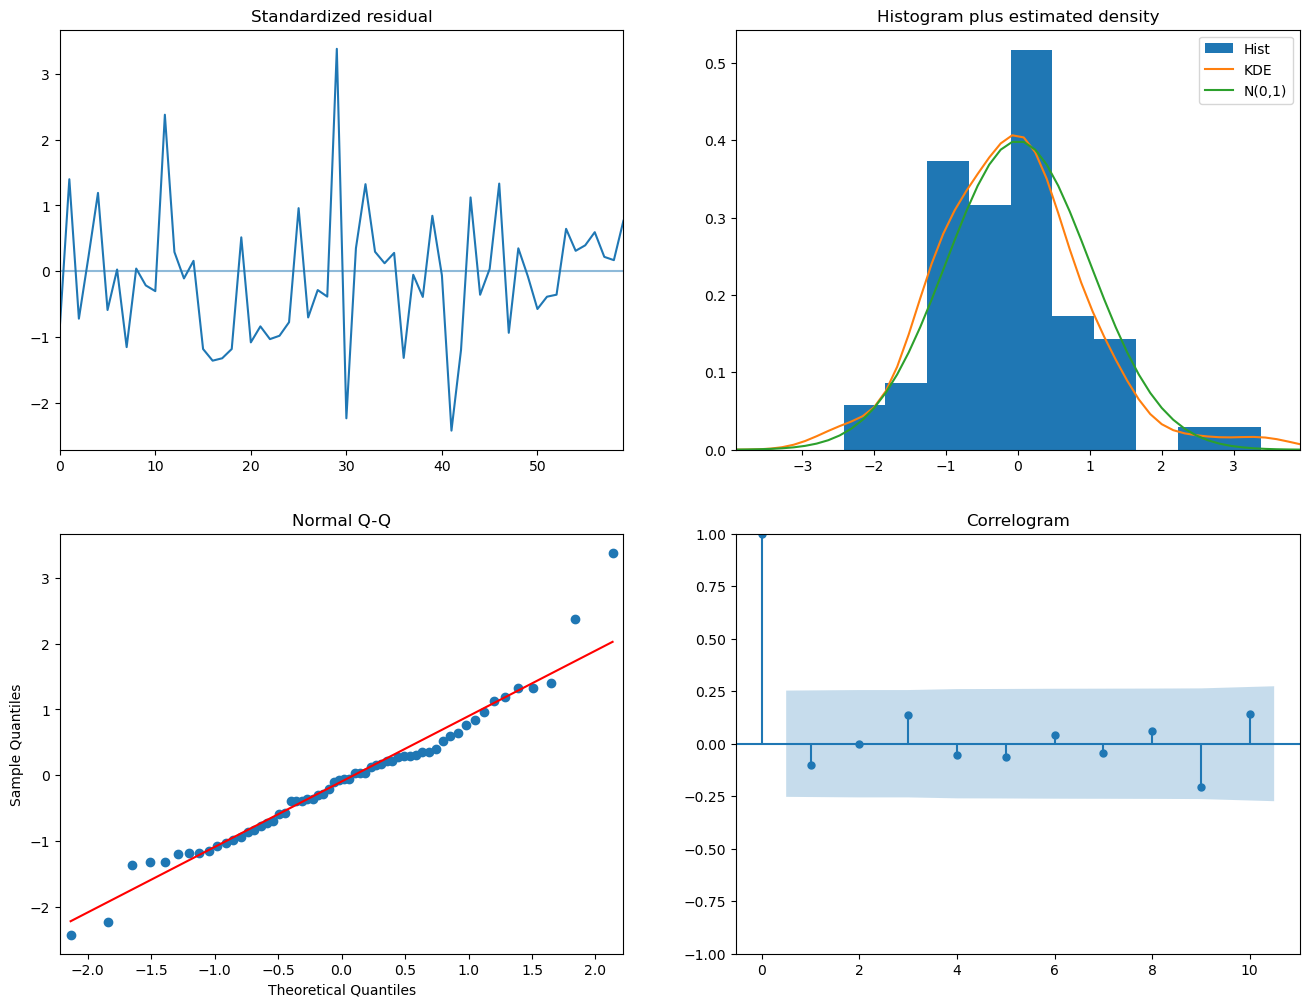

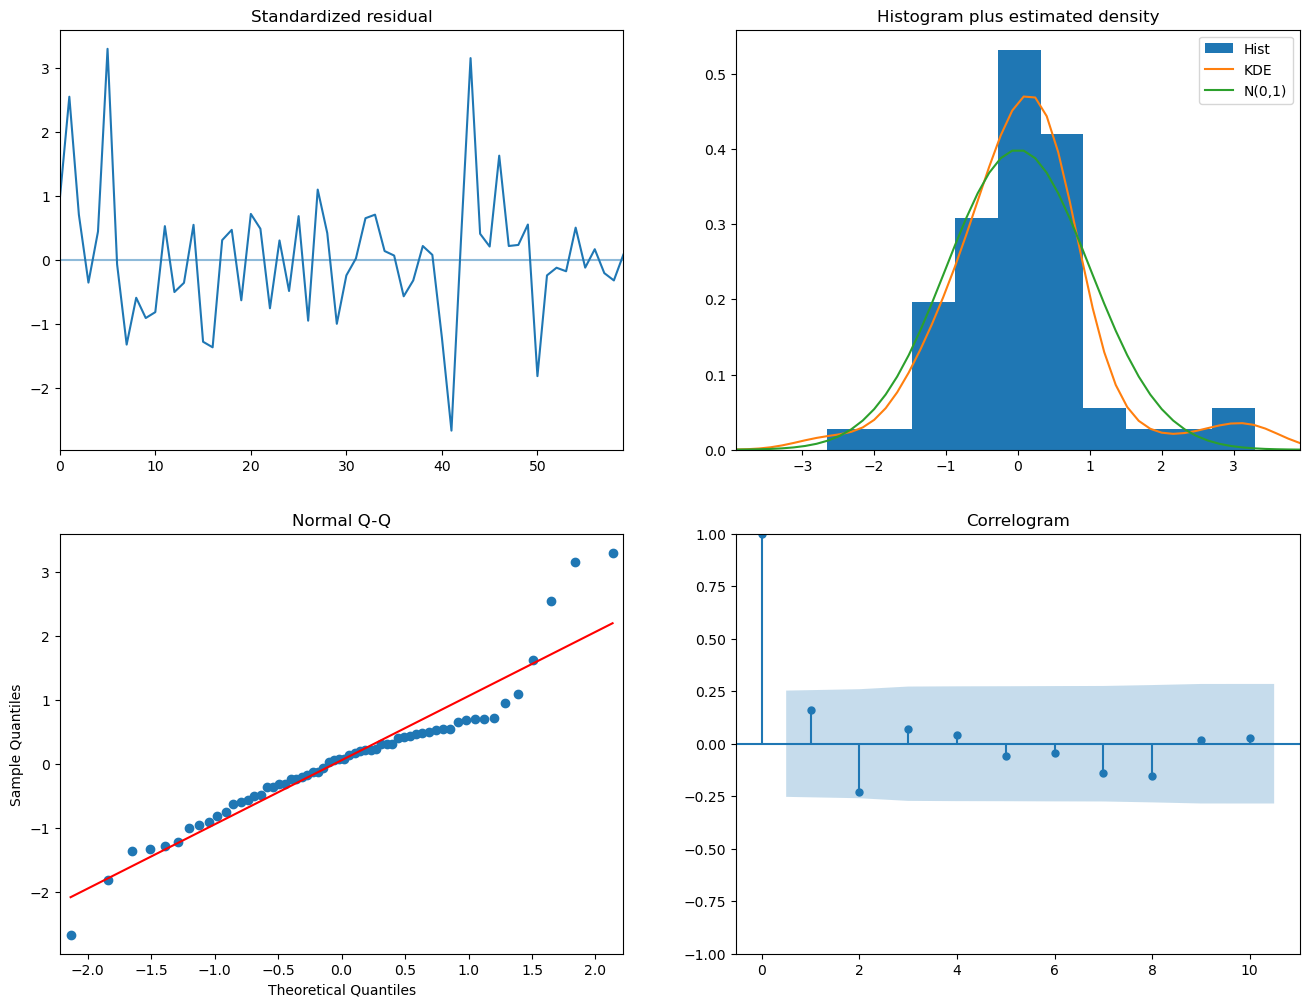

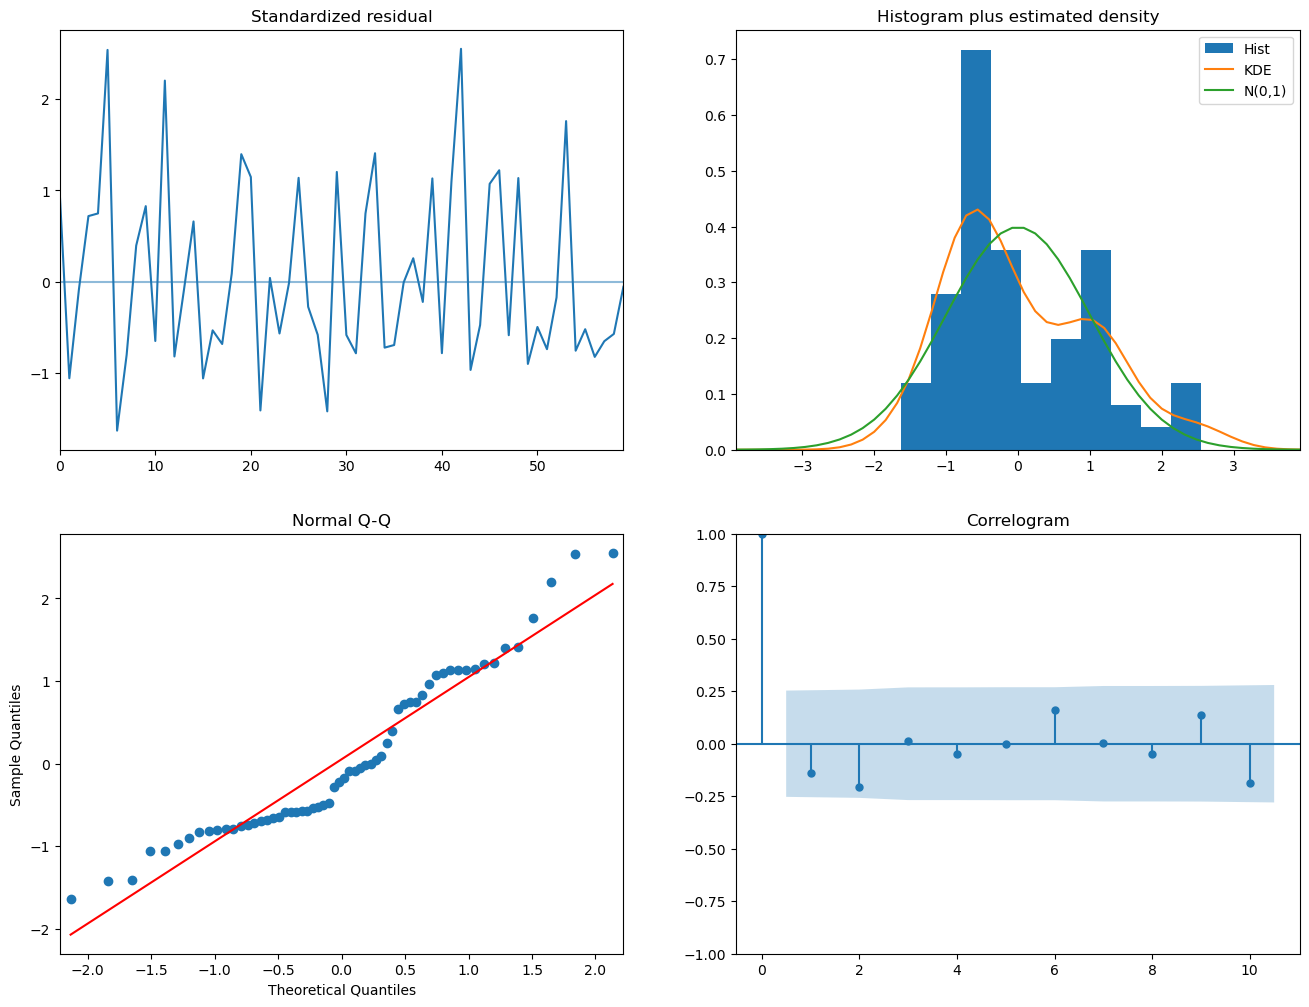

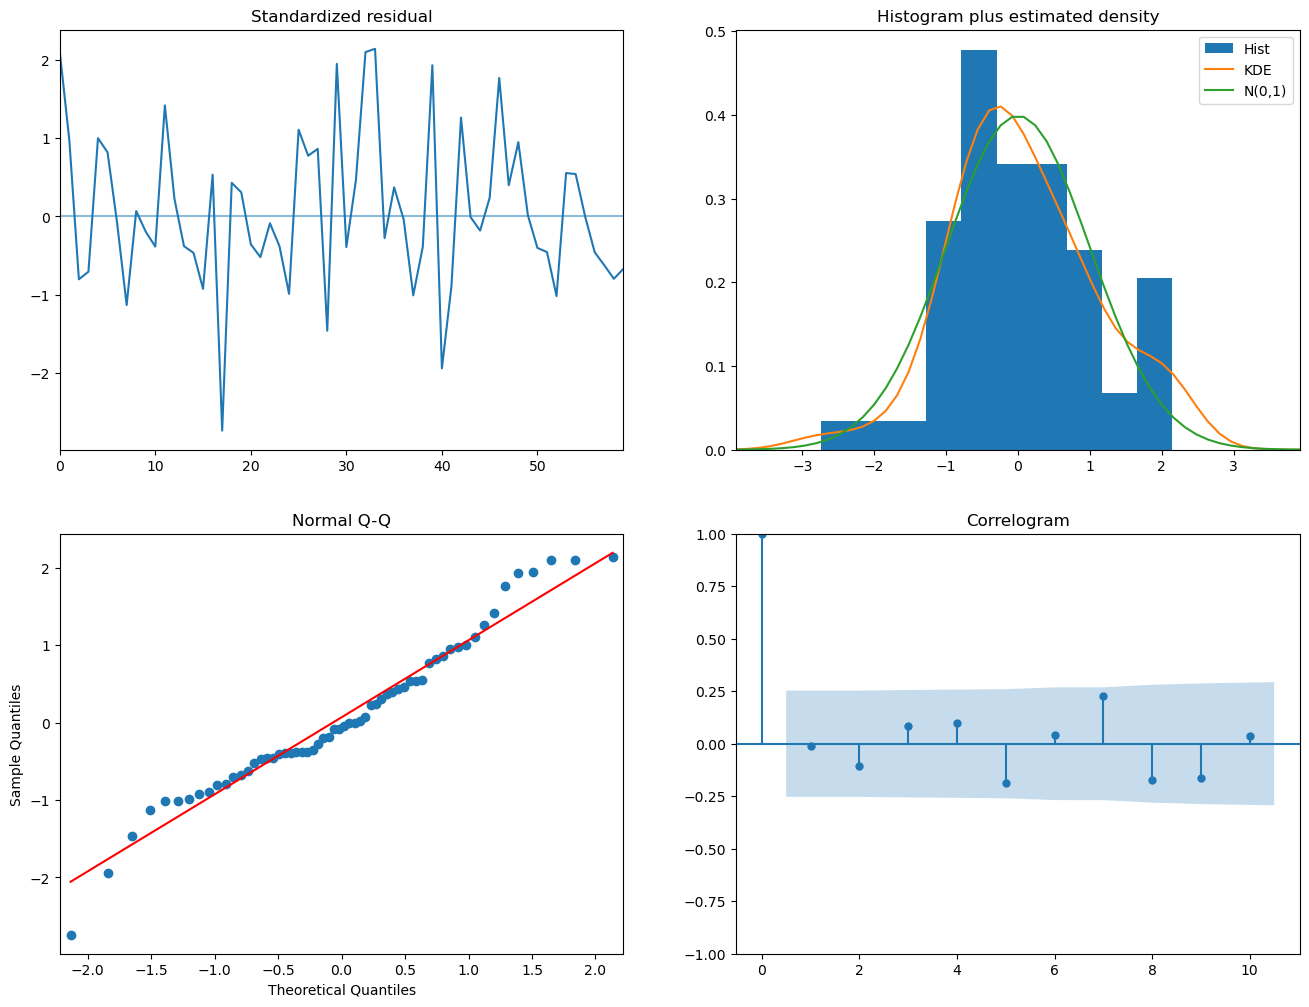

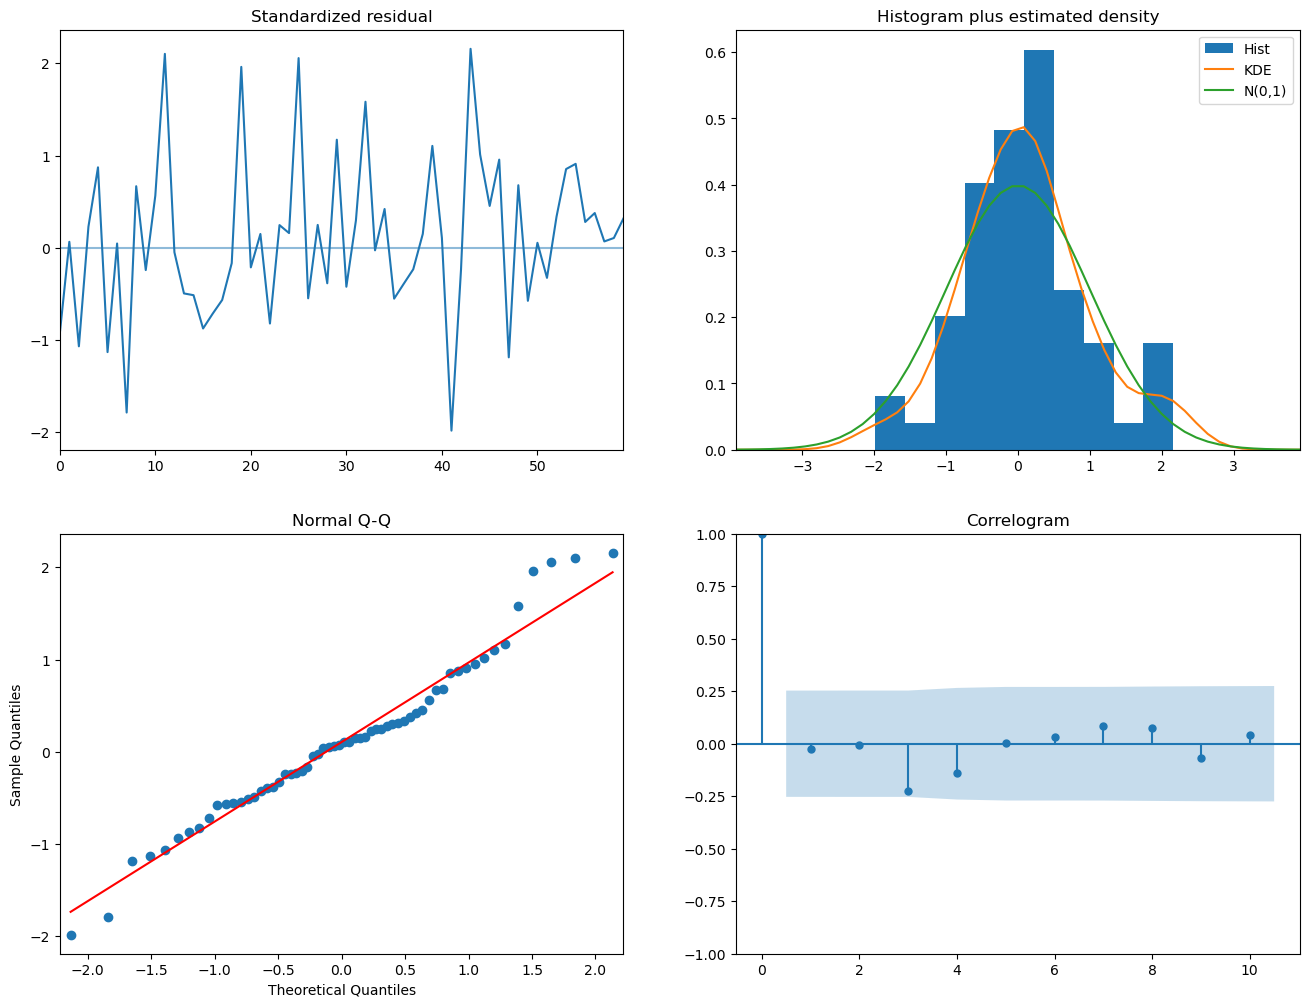

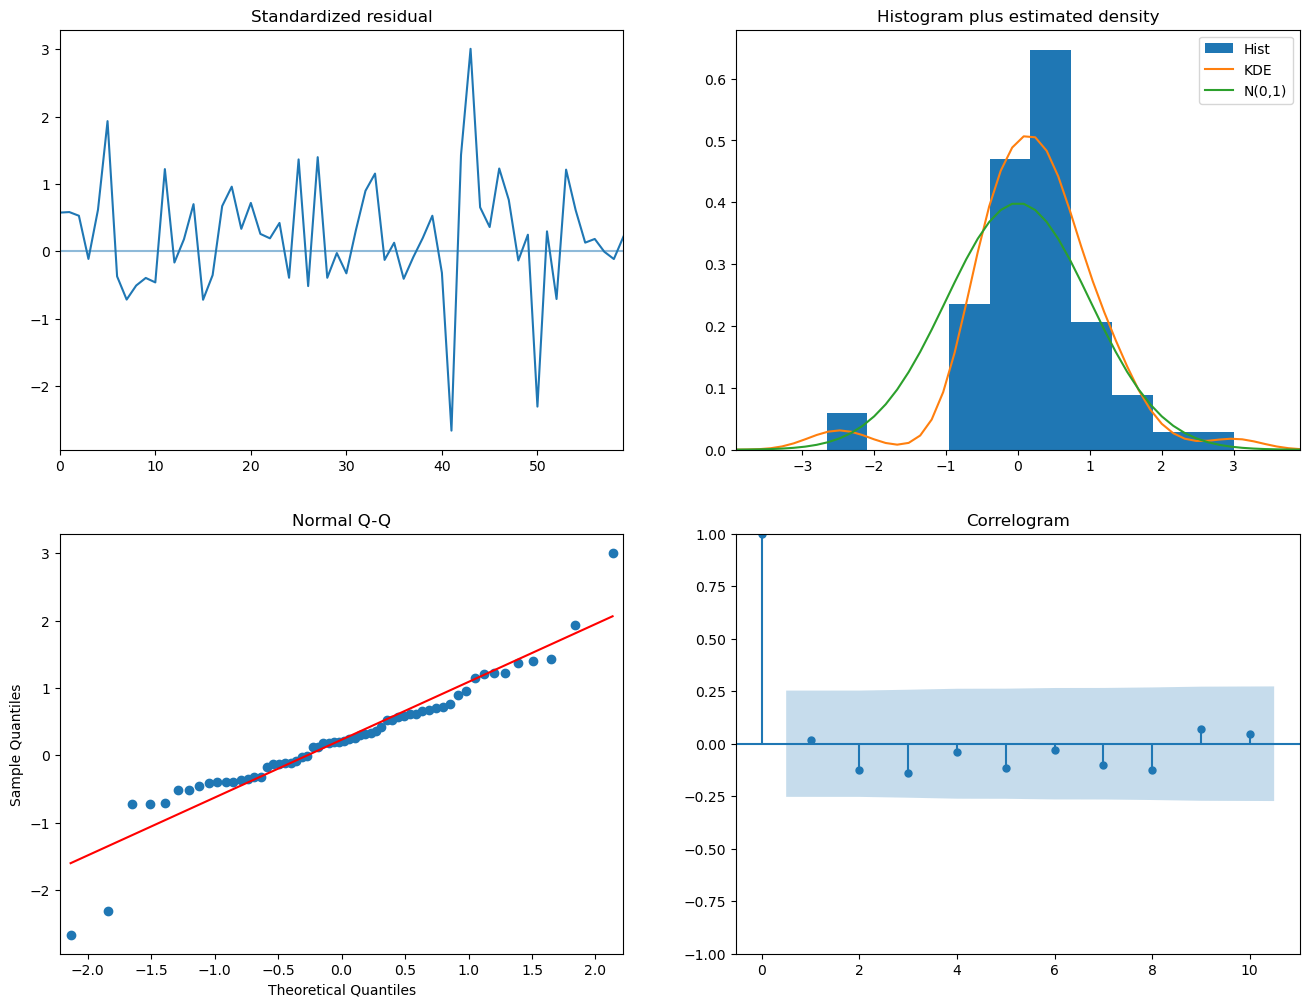

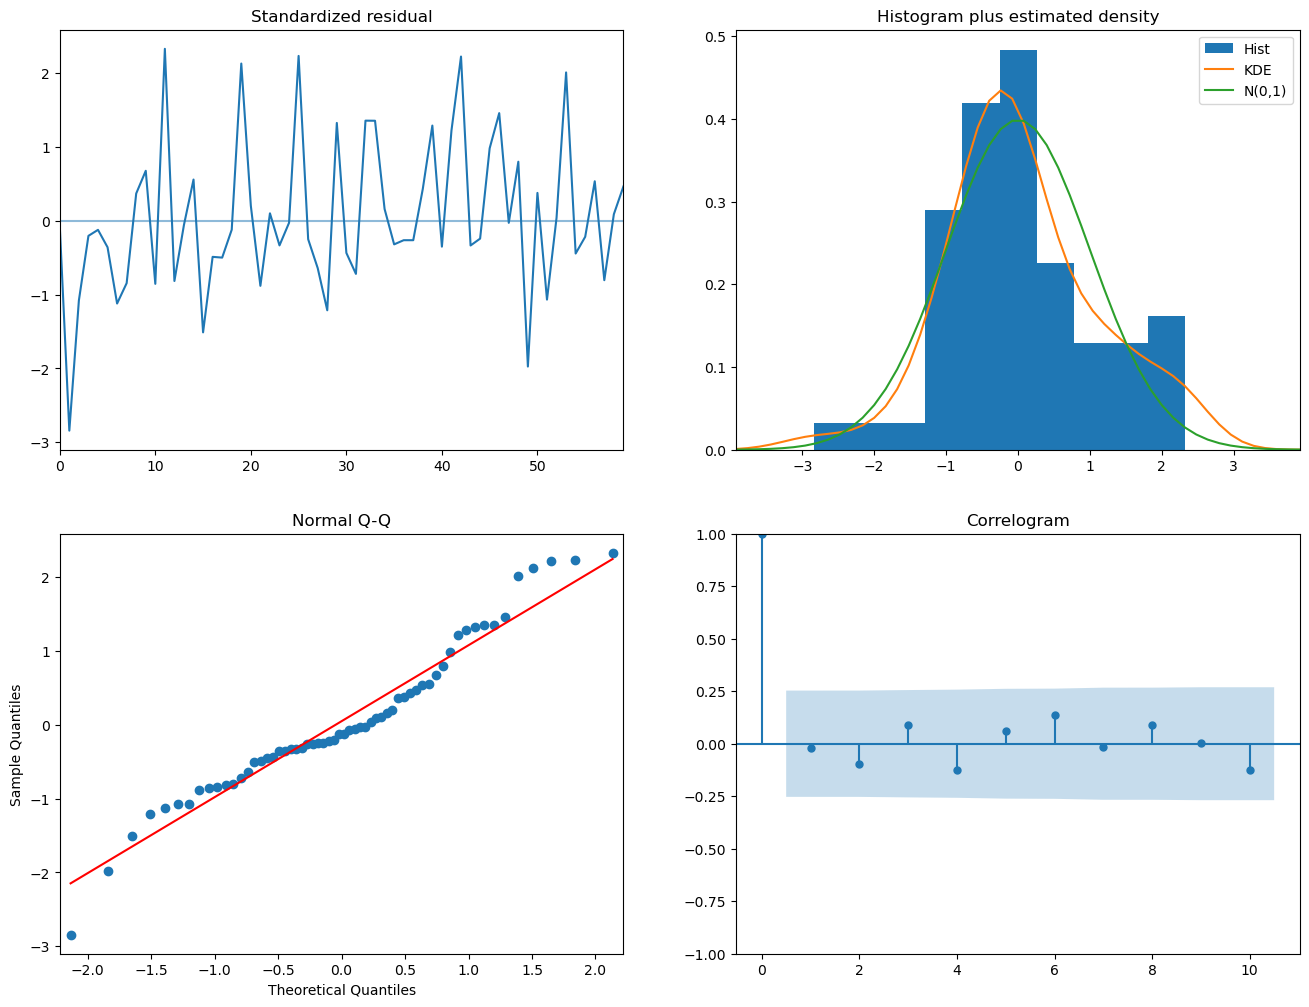

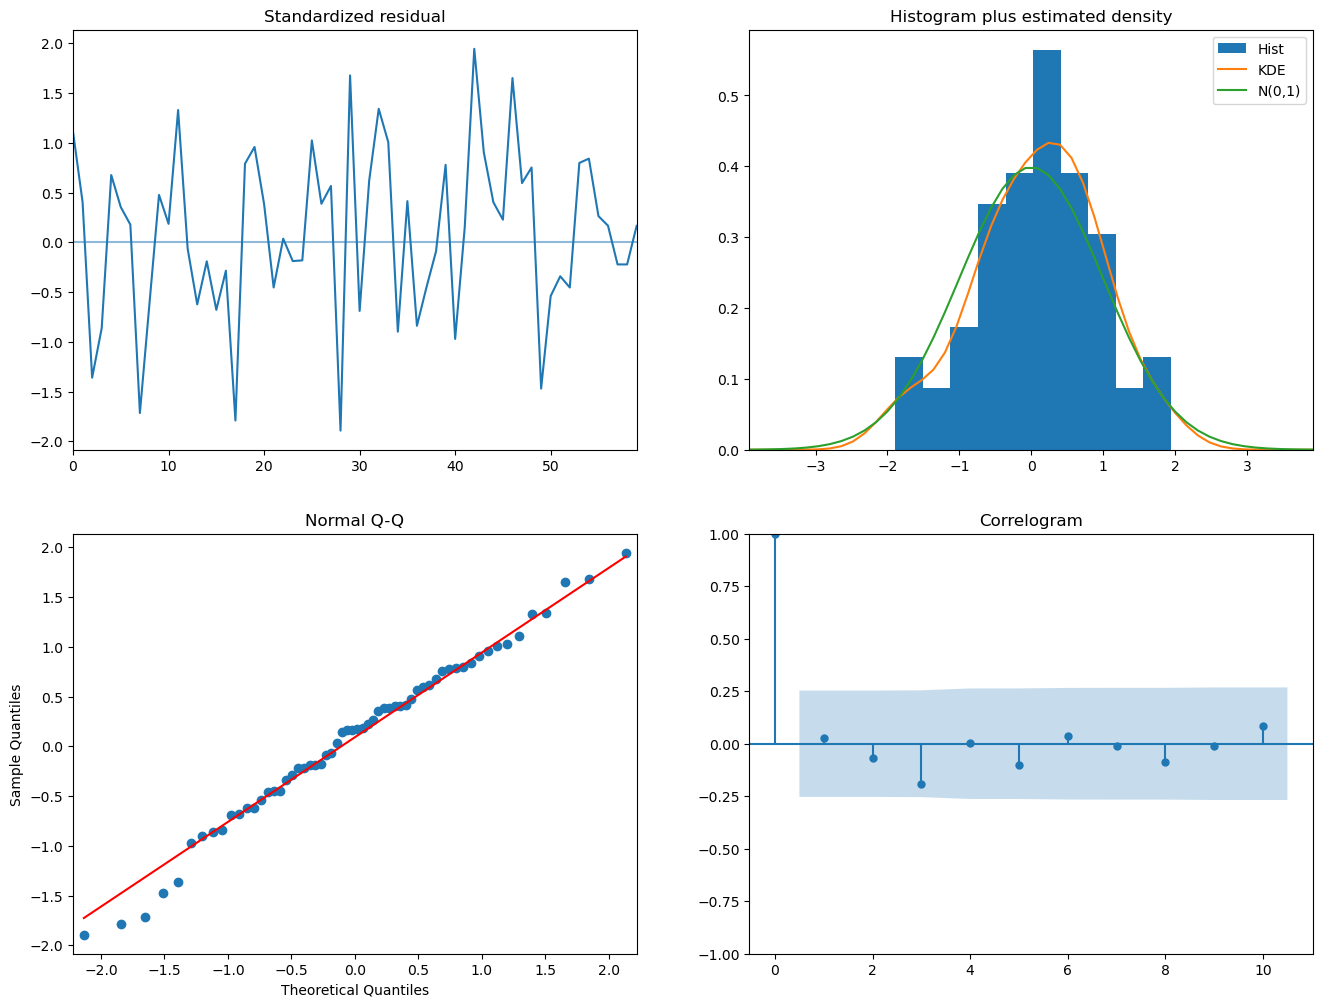

In [63]:
countr,predicition_q = model('Quantity')
countr,predicition_s = model('Shipment carton number')

In [64]:
mae = mean_squared_error(df_CH_1[62:]['Quantity'].values, workload_test[workload_test['country']=='CH']['predict_quantity'].values)
print("mean_absolute_error： ", mae)

mean_absolute_error：  7531.483071947201


In [20]:
workload = pd.DataFrame()
workload['country'] = countr
workload['predict_quantity'] = predicition_q
workload['predict_Shipment_carton'] = predicition_s
workload.explode(['predict_quantity','predict_Shipment_carton'])

,country,predict_quantity,predict_Shipment_carton
0,DE,1706.371052,24251039268.441971
0,DE,1413.512968,21618373650.267376
0,DE,1443.231458,23706497323.09819
0,DE,1472.949949,25287525361.728806
0,DE,1502.668439,26861716179.31472
0,DE,1532.386929,28443839454.446171
0,DE,1562.105419,30025127533.088924
0,DE,1591.823909,31606402140.129192
1,NL,820.963237,11474634290.91832
1,NL,806.304199,10747576681.54854


In [25]:
df_CH_1

,Order creation date,Quantity,Shipment carton number
0,2017-05-15,278,3557753276
1,2017-05-16,61,784105742
2,2017-05-17,260,3290153033
3,2017-05-18,392,5046977783
4,2017-05-19,266,2818577937
...,...,...,...
65,2017-07-19,290,4035909598
66,2017-07-20,238,3362188104
67,2017-07-21,299,4088514442
68,2017-07-22,192,2721538285


below tablw show the prediction of Quanity and Shipment carton Quanity

# Weekday workload

## How is the workload distributed between the weekdays? 

In [ ]:
df1['Delivery time date'] = pd.to_datetime(df1['Delivery time']).dt.date
df1['Delivery time t'] = pd.to_datetime(df1['Delivery time']).dt.time
df1["order_workday"] = df1['Order processed date'].dt.day_name()
df1["delivery_workday"] = pd.to_datetime(df1['Delivery time date'], errors='coerce').dt.day_name()
df1["order_month"]= df1['Order processed date'].dt.month
df1["delivery_month"] = pd.to_datetime(df1['Delivery time date'], errors='coerce').dt.month
df1.head()

In [ ]:
# total workload during the whole period
weekday_journeys = df1.pivot_table(index = ['order_workday'],values = 'Quantity', aggfunc = 'sum')
weekday_journeys = weekday_journeys.reset_index()
x = ['Monday', 'Tuesday', 'Wednesday',  'Thursday','Friday', 'Saturday']
y = [weekday_journeys[weekday_journeys.order_workday==i].Quantity.values[0] for i in x]

plt.bar(x,y)
plt.ylabel('Total no.of Quantity')
plt.title('Quantity by Day of Week during 2017-05~2017-10')
plt.xticks(rotation=270)

In [ ]:
#every month weekday workload
df_wm = df1.pivot_table(index = ['order_month','order_workday'],values = ['Quantity'], aggfunc = 'sum')
df_wm = df_wm.reset_index()
df_map = pd.DataFrame({'order_workday': ['Monday', 'Tuesday', 'Wednesday',  'Thursday','Friday', 'Saturday']}).reset_index().set_index('order_workday')
df_wm['order'] = df_wm['order_workday'].map(df_map['index'])
df_wm.sort_values('order', inplace=True)
plt.figure()
for i in range(5,11):
    df_wm[df_wm['order_month']==i].plot.bar(x='order_workday',y=['Quantity'],subplots=True)
    plt.title(f'Quantity by Day of Week on 2017-{i}')
    

As shown in the below imgaes, there are the highest workload on Monday during 5 months between 2017-05 and 2017-10.Then the workload goes down until Friday, it goes up and then down. In June and August, the trend shows slight different. In August, the highest workload in Wednesday.In June, The overall trend of the graph indicates a decrease starting from Monday, followed by an increase from Wednesday to Friday. The quantity begins at a high point on Monday and then gradually declines until reaching a trough on Wednesday. From Wednesday onwards, there is a steady rise in quantity, peaking again on Friday, possibly approaching or slightly below the Monday's peak. Saturday marks the lowest point of the week, with the quantity hitting its minimum.

In September, the graph shows that Wednesday has the workload.In October, only Friday shows workload.